In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OCP_algorithms import hospital_capacity_objective_solve, quadratic_objective_solve, week_objective_solve

from SIR_Plotting_Routines import *
import pysindy as ps
import glob
import pandas as pd


from os.path import basename
import os
import sys


cwd = os.path.dirname(os.path.abspath(''))
# sys.path.append(cwd + '/Cpp/build/Binders/')
import pyFROLS as pf

DATA_DIR = cwd + '/Cpp/data/'
FIGURE_DIR = cwd + '/../../figures/'

In [2]:
N_pop = 100
p_ER = 1
d_max = 1
N_output_max = 80
Nx = 3
Nu = 1
Nt = 50
er_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
er_features = er_model.read_csv(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')


In [3]:
qr_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
qr_features = qr_model.read_csv(DATA_DIR + 'Quantile_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')

In [4]:
from pysindy_casadi_converter import construct_mx_equations
import casadi as cs


In [5]:
DATA_DIR

'/home/man/Documents/Bernoulli_MC/Cpp/data/'

In [6]:
def load_SIR_trajectories():
    trajs = glob.glob(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/trajectory*.csv')
    dfs = [pd.read_csv(traj) for traj in trajs[:100] if "Quantile" not in traj]
    
    # print(dfs[0].columns)
    N_traj = len(dfs)
    X = [df[['S', 'I', 'R']].to_numpy() for df in dfs]
    U = [df['p_I'].to_numpy() for df in dfs]

    return X, U

X_sim, U_sim = load_SIR_trajectories()
#get mean of all X_sim
X_mean = np.mean(np.array(X_sim), axis=0)
U_mean = np.mean(np.array(U_sim), axis=0)

In [7]:
import random
N_sims = 100
p_I0 = 0.1
# #generate integer seeds
# qr_seeds = [random.randint(0, 1000000) for i in range(N_sims)]

# er_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, p_I0, er_seeds, Nt, 100)
# qr_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, p_I0, qr_seeds, Nt, 100)
# er_X_list = [np.array([x[0], x[1], x[2]]) for x in er_sims]
# qr_X_list = [np.array([x[0], x[1], x[2]]) for x in qr_sims]
graph_seed = 777
G_structure = pf.generate_SIR_ER_graph(N_pop, p_ER, graph_seed)
G = pf.generate_Bernoulli_SIR_Network(G_structure, p_I0, graph_seed, 0)


In [8]:
G.reset()
G.initialize()
p_gen = pf.MC_SIR_Params()
p_gen.N_pop = 100
p_gen.p_ER = 1
p_gen.p_I0 = 0.1
er_param = pf.Regressor_Param()
er_param.tol = 1e-4
er_regressor = pf.ERR_Regressor(er_param)


er_seeds = [random.randint(0, 1000000) for i in range(N_sims)]

In [9]:
Nc = 10
Wu = 1
x  = cs.MX.sym('x', Nx)
u  = cs.MX.sym('u', Nu)

p_step = pf.SIR_Param()
p_step.p_R = 0.1

G.reset()
G.initialize()
er_x_preds = []
er_us = []
rds = []
er_true_traj = np.zeros((Nx, (Nc)*7 + 1))
er_true_traj[:,0] = G.population_count()
er_true_u = np.zeros(((Nc)*7))
for i in range(Nc):
    rd = pf.MC_SIR_simulations_to_regression(G_structure, p_gen, er_seeds, Nt)
    rds.append(rd)
    features = [er_regressor.transform_fit(rd.X, rd.U, rd.Y[:, i:i+1], er_model) for i in range(rd.Y.shape[1])]
    er_X_mean = np.mean(np.reshape(rd.X, (N_sims, Nt, Nx)), axis=0)
    er_U_mean = np.mean(np.reshape(rd.U, (N_sims, Nt, Nu)), axis=0)
    er_model.feature_summary(features)
    F_ODE = cs.Function("F_ODE_" + str(i), [x, u], [cs.vertcat(*construct_mx_equations(x, u, er_model, features))])
    er_sol, er_x_pred, er_u = week_objective_solve(er_X_mean, er_U_mean, Wu, F_ODE, Nt, N_pop)
    er_x_preds.append(er_x_pred)
    er_us.append(er_u)
    p_step.p_I = er_u[0]
    for j in range(7):
        G.advance(p_step)
        er_true_traj[:,i*7+j+1] = G.population_count()
        er_true_u[i*7+j] = p_step.p_I
    # p_gen.p_I_max = 2*np.max(er_u)



    

       y           Feature           g            Theta          f_ERR           Tag      
       0             x0            0.979          1.001          0.998       REGRESSION          4       
       0           x0x1u0         -0.277         -0.316          0.001       REGRESSION         13       
       0          x0x1x2u0         0.007          0.007          0.000       REGRESSION         15       
       0            x0u0          -2.796         -2.796          0.000       REGRESSION          8       
       1             x1            0.989          0.919          0.985       REGRESSION          3       
       1           x0x1u0          0.386          0.273          0.007       REGRESSION         13       
       1          x0x1x2u0        -0.007         -0.007          0.001       REGRESSION         15       
       1            x0u0           2.389          2.389          0.000       REGRESSION          8       
       2             x2            1.016          1.000      

ValueError: too many values to unpack (expected 3)

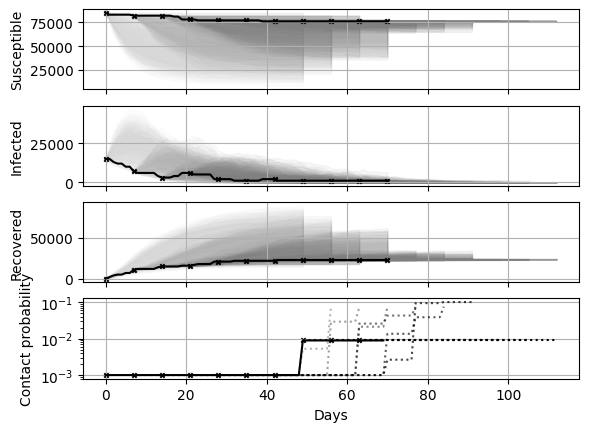

In [ ]:
fig, ax = plt.subplots(4)
alphas = np.linspace(0.2, 1, Nc)
t_offset = 0
fake_scale = 1000
for (alpha, rd, er_x_pred, er_u) in zip(alphas, rds, er_x_preds, er_us):
    t = np.array(range(t_offset, t_offset + Nt))
    t_offset += 7
    plot_sim_comparison_SIR(ax, rd, er_x_pred, er_u, t, N_sims, alpha_multiplier=alpha, scale=fake_scale)
t_full = np.array(range(0, er_true_traj.shape[1]))
control_points = np.array(range(0, er_true_traj.shape[1], 7))
#scatter at control points
ax[-1].plot(t_full[:-1], er_true_u, color='black')
_ = [ax[i].scatter(control_points, er_true_traj[i, control_points]*fake_scale, color='black', marker='x', s=10) for i in range(Nx)]
ax[-1].scatter(control_points[:-1], er_true_u[control_points[:-1]], color='black', marker='x', s=10)
_ = [x.plot(t_full, xi*fake_scale, color='black') for x, xi in zip(ax[:-1], er_true_traj)]
ax[-1].set_xlabel('Days')
_ = [x.grid() for x in ax]

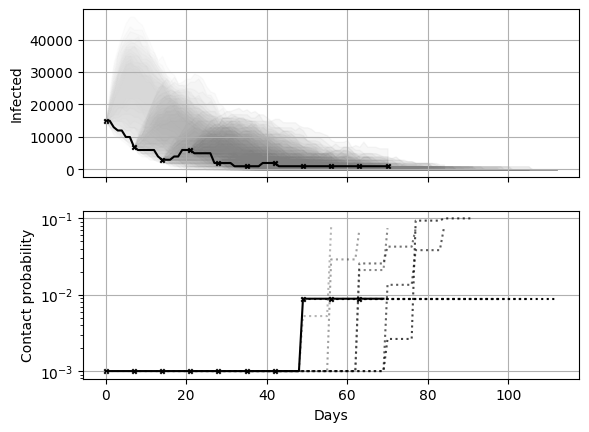

In [ ]:
fig, ax = plt.subplots(2)
alphas = np.linspace(0.2, 1, Nc)
t_offset = 0
for (alpha, rd, er_x_pred, er_u) in zip(alphas, rds, er_x_preds, er_us):
    t = np.array(range(t_offset, t_offset + Nt))
    t_offset += 7
    plot_sim_comparison_SIR(ax, rd, er_x_pred, er_u, t, N_sims, alpha_multiplier=alpha, scale=fake_scale, plot_idx=[1])
t_full = np.array(range(0, er_true_traj.shape[1]))
control_points = np.array(range(0, er_true_traj.shape[1], 7))
#scatter at control points
ax[-1].plot(t_full[:-1], er_true_u, color='black')
ax[0].scatter(control_points, er_true_traj[1, control_points]*fake_scale, color='black', marker='x', s=10)
ax[-1].scatter(control_points[:-1], er_true_u[control_points[:-1]], color='black', marker='x', s=10)
ax[0].plot(t_full, er_true_traj[1,:]*fake_scale, color='black')
ax[-1].set_xlabel('Days')
_ = [x.grid() for x in ax]